<a href="https://colab.research.google.com/github/Edimer/My_CloudComputing/blob/master/XGBS9_SideralN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[UNICEF Arm 2030 Vision #1: Flood Prediction in Malawi](https://zindi.africa/competitions/2030-vision-flood-prediction-in-malawi/leaderboard)
=============================================
[Edimer David Jaramillo](https://edimer.github.io/)     
Abril de 2020

## Instalando y cargando bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
install.packages("ParBayesianOptimization", dependencies = TRUE)
install.packages("mlr3verse", dependencies = TRUE)
install.packages("rBayesianOptimization", dependencies = TRUE)

library(tidyverse)
library(h2o)
library(ParBayesianOptimization)
library(mlr3verse)
library(rBayesianOptimization)

## Importando datos

In [0]:
load("/content/dataTrain.Rdata")
load("/content/dataTest.Rdata")

## Modelo XGBoost (Optimización Bayesiana)

In [0]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Train y Test h2o
df_train <- dataTrain %>%
   select(-Square_ID)

# Datos h2o
datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.8, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_h2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_h2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_h2o")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

# Modelo XGB h2o (función de scoring para optimización bayesiana)
scoring_function <- function(learn_rate, max_depth, subsample,
                             min_rows, col_sample_rate, colsample_bytree,
                             gamma, ntrees) {
  nfolds <- 5                             
  metrica <- "RMSE"

  xgb <- h2o.xgboost(
                  # Modelo
                   x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,ignore_const_cols = TRUE
                  
                  # Aprendizaje del modelo
                  ,learn_rate = learn_rate
                  ,ntrees = ntrees
                  ,subsample = subsample
                  ,col_sample_rate = col_sample_rate
                  ,colsample_bytree = colsample_bytree
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = gamma
                  ,max_depth = max_depth
                  ,min_rows = min_rows

                  # Validación y stop
                  ,nfolds = nfolds
                  ,seed = 123
                  ,max_runtime_secs = 900
                  ,stopping_tolerance  = 0.001
                  ,stopping_rounds = 10
                  ,score_tree_interval = 100)
  
  score <- h2o.performance(model = xgb, xval = TRUE)@metrics[[metrica]]
  
  # Si la métrica es un error, dado que el proceso es de maximización, se convierte
  # en negativo.
  score <- -score
  return(list(Score = score))
}                 

## Búsqueda de hiperparámetros

In [0]:
limites <- list( 
              learn_rate  = c(0.001, 0.5),
              max_depth   = c(1L, 50L), 
              subsample = c(0.5, 1),
              min_rows = c(1L, 30L),
              col_sample_rate = c(0.4, 1),
              colsample_bytree = c(0.5, 1),
              gamma = c(1L, 10L),
              ntrees = c(100L, 10000L)
              )

## Optimización

In [11]:
set.seed(123)
bayes_opt <- BayesianOptimization(
              FUN = scoring_function, 
              bounds = limites,
              init_points = 4,
              n_iter = 5,
              acq = "ucb",
              kappa = 2.576,
              eps = 0.0,
              verbose = TRUE
            )

elapsed = 249.92	Round = 1	learn_rate = 0.1445	max_depth = 47.0000	subsample = 0.7757	min_rows = 21.0000	col_sample_rate = 0.5477	colsample_bytree = 0.9448	gamma = 7.0000	ntrees = 2963.0000	Value = -0.1137 
elapsed = 90.21	Round = 2	learn_rate = 0.3944	max_depth = 3.0000	subsample = 0.7283	min_rows = 18.0000	col_sample_rate = 0.4252	colsample_bytree = 0.8464	gamma = 7.0000	ntrees = 1556.0000	Value = -0.1197 
elapsed = 626.31	Round = 3	learn_rate = 0.2051	max_depth = 27.0000	subsample = 0.9784	min_rows = 4.0000	col_sample_rate = 0.5968	colsample_bytree = 0.8203	gamma = 6.0000	ntrees = 9634.0000	Value = -0.1037 
elapsed = 213.57	Round = 4	learn_rate = 0.4416	max_depth = 45.0000	subsample = 0.7267	min_rows = 27.0000	col_sample_rate = 0.9727	colsample_bytree = 0.9971	gamma = 6.0000	ntrees = 9033.0000	Value = -0.1195 
elapsed = 382.92	Round = 5	learn_rate = 0.2794	max_depth = 39.0000	subsample = 0.8996	min_rows = 21.0000	col_sample_rate = 0.8870	colsample_bytree = 0.8213	gamma = 1.0000	ntre

## Resultados de optimización

In [13]:
bayes_opt$History

Round,learn_rate,max_depth,subsample,min_rows,col_sample_rate,colsample_bytree,gamma,ntrees,Value
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.14450118,47,0.7757175,21,0.5476526,0.9447697,7,2963,-0.1137066
2,0.39436426,3,0.7283074,18,0.4252357,0.8464017,7,1556,-0.1196759
3,0.20507948,27,0.9784167,4,0.5967524,0.8202534,6,9634,-0.1037477
4,0.44162568,45,0.7266671,27,0.9727022,0.9971349,6,9033,-0.1195300
5,0.27937987,39,0.8996445,21,0.8870141,0.8212911,1,4771,-0.1008241
6,0.01015726,49,0.5000000,25,0.5297257,0.9750883,1,9711,-0.1077814
7,0.08681706,3,0.9256887,1,0.7445305,0.9114664,3,8657,-0.1046291
8,0.48376060,24,0.8486835,8,0.9603877,0.5091690,6,2715,-0.1062535
9,0.18705268,1,1.0000000,30,0.8428552,0.7502931,3,372,-0.1397937


## Mejores parámetros

In [14]:
bayes_opt$Best_Par

learn_rate        max_depth        subsample         min_rows 
       0.2793799       39.0000000        0.8996445       21.0000000 
 col_sample_rate colsample_bytree            gamma           ntrees 
       0.8870141        0.8212911        1.0000000     4771.0000000

## Modelo XGBoost Optimizado

In [16]:
xgb <- h2o.xgboost(
                  # Modelo
                   x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,ignore_const_cols = TRUE
                  ,model_id = "xgb_s9"
                  
                  # Aprendizaje del modelo
                  ,learn_rate = 0.28
                  ,ntrees = 4771
                  ,subsample = 0.89
                  ,col_sample_rate = 0.88
                  ,colsample_bytree = 0.82
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 1
                  ,max_depth = 39
                  ,min_rows = 21

                  # Validación y stop
                  ,nfolds = 10
                  ,seed = 123
                  ,max_runtime_secs = 3600
                  ,stopping_tolerance  = 0.001
                  ,stopping_rounds = 50
                  ,score_tree_interval = 100)

  |======================================================================| 100%


In [17]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb_s9 
Model Summary: 
  number_of_trees
1            4771


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.004313804
RMSE:  0.06567955
MAE:  0.0248084
RMSLE:  0.04776604
Mean Residual Deviance :  0.248465


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  0.008981471
RMSE:  0.09477063
MAE:  0.03308512
RMSLE:  0.06631421
Mean Residual Deviance :  0.2548203


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.009316416
RMSE:  0.09652159
MAE:  0.03419308
RMSLE:  0.06845179
Mean Residual Deviance :  0.2702919


Cross-Validation Metrics Summary: 
                              mean           sd  cv_1_valid  cv_2_valid
mae                    0.034193877  0.002069272  0.03632843 0.032334756
mean_residual_deviance  0.27019784  0.017189154  0.27531445  0.25078523
ms

## Predicciones

In [18]:
# ============================= Predicciones ====================================== #

# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(dataTest)) %>%
  as.data.frame() %>% pull(predict)
predichos_subm[predichos_subm > 1] <- 1 
dataTest %>% 
  select(Square_ID) %>% 
  mutate(target = predichos_subm) ->
  subm9


# Exportando predicciones
write.csv(subm9, file = "subm9.csv", row.names = FALSE)

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.06567955
Test,0.09598423


## Importancia de variables

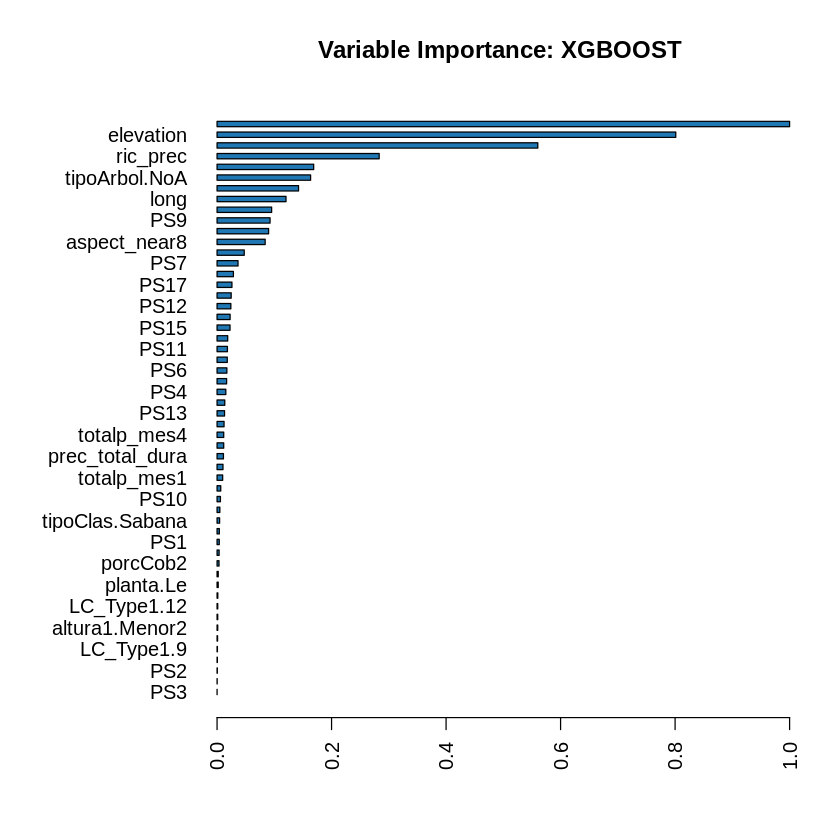

In [19]:
h2o.varimp_plot(xgb, num_of_features = ncol(dataTrain))

## Guardar modelo

In [20]:
h2o.saveModel(xgb, path = "XGB_Subm9", force = TRUE)

[1] "/content/XGB_Subm9/xgb_s9"

## Gráficos

  |======================================================================| 100%


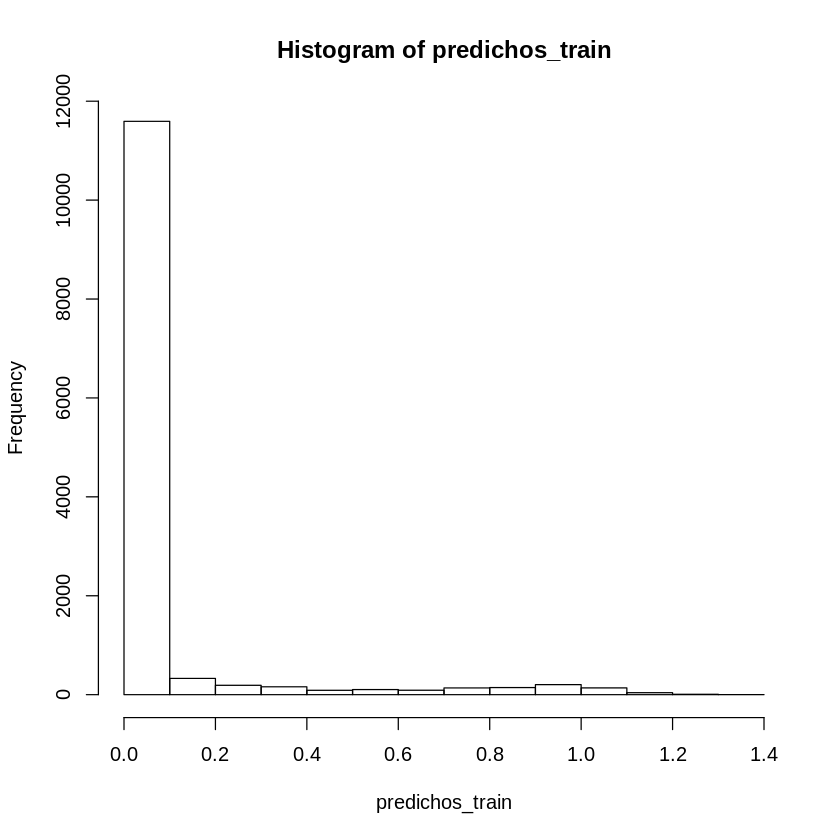

In [21]:
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)
hist(predichos_train)

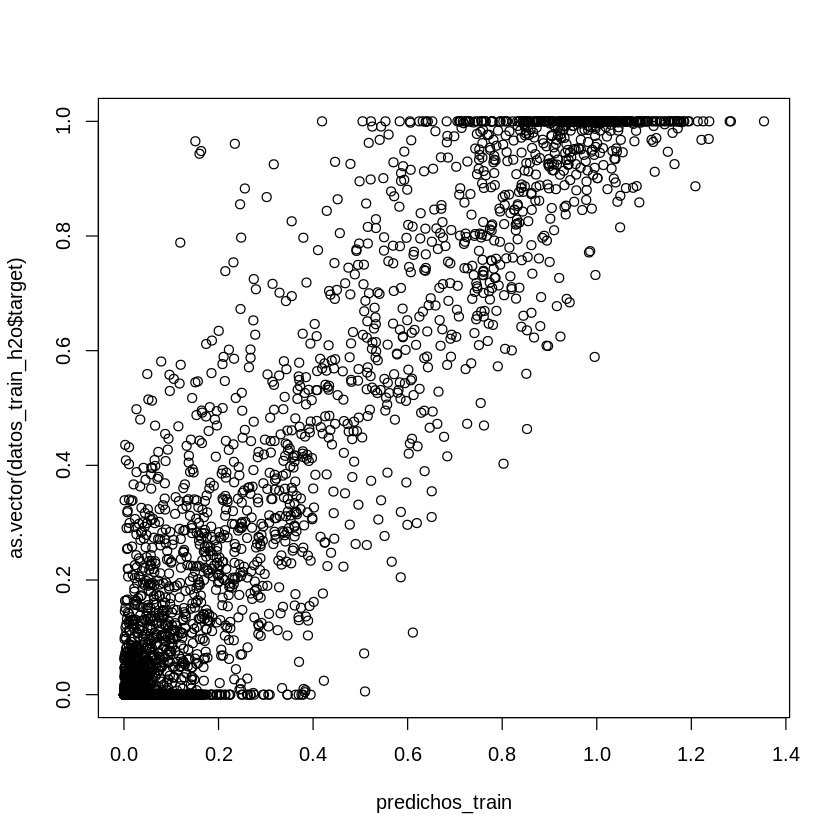

In [22]:
plot(predichos_train, as.vector(datos_train_h2o$target))

  |======================================================================| 100%


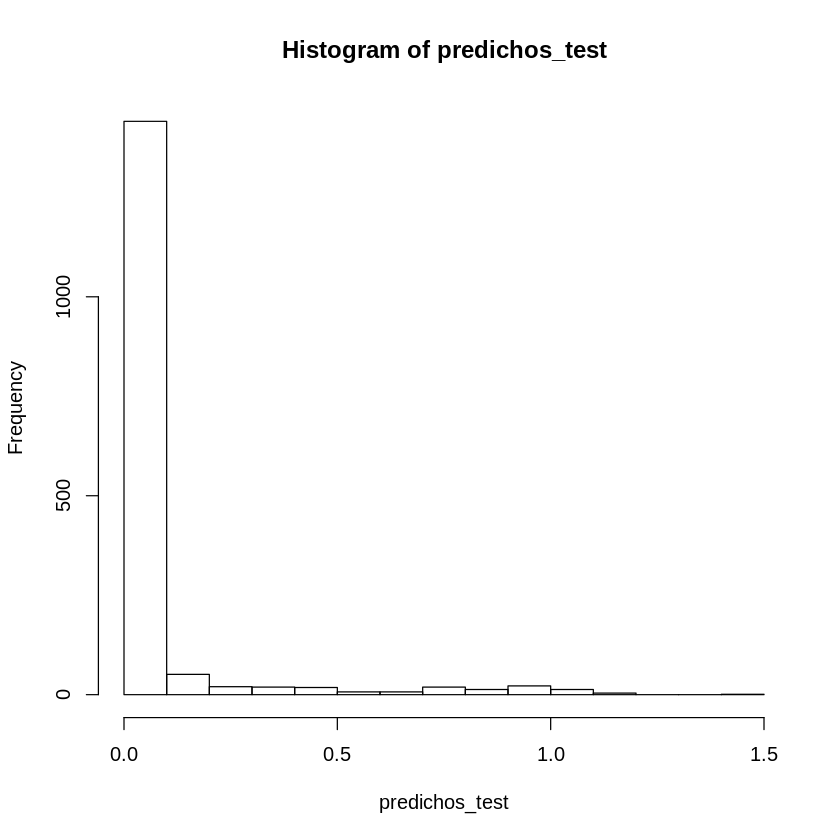

In [23]:
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict) 
hist(predichos_test)

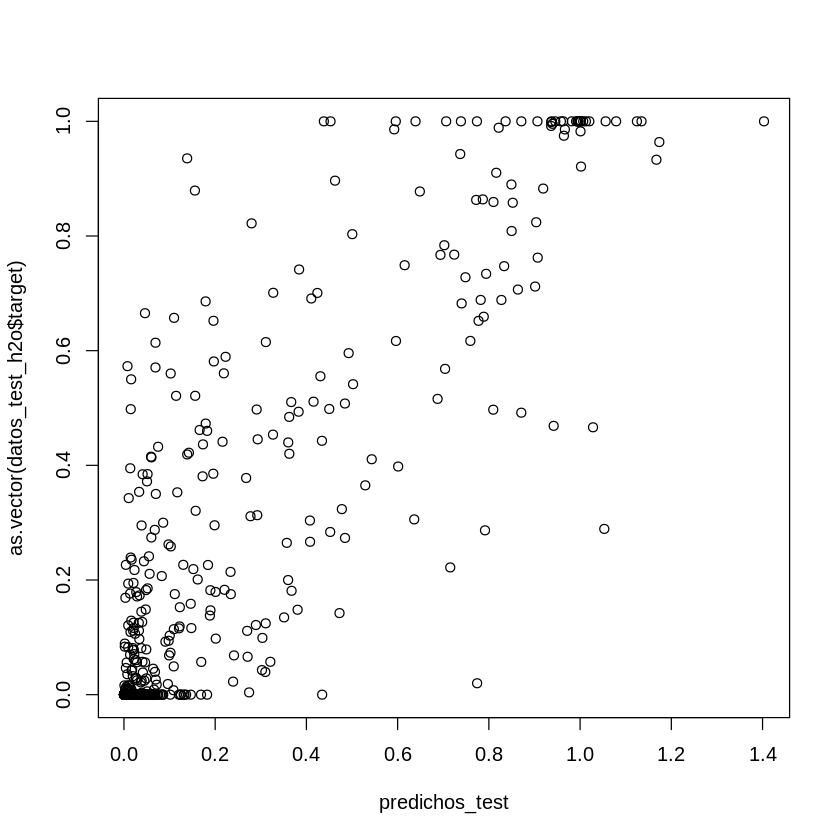

In [24]:
plot(predichos_test, as.vector(datos_test_h2o$target))

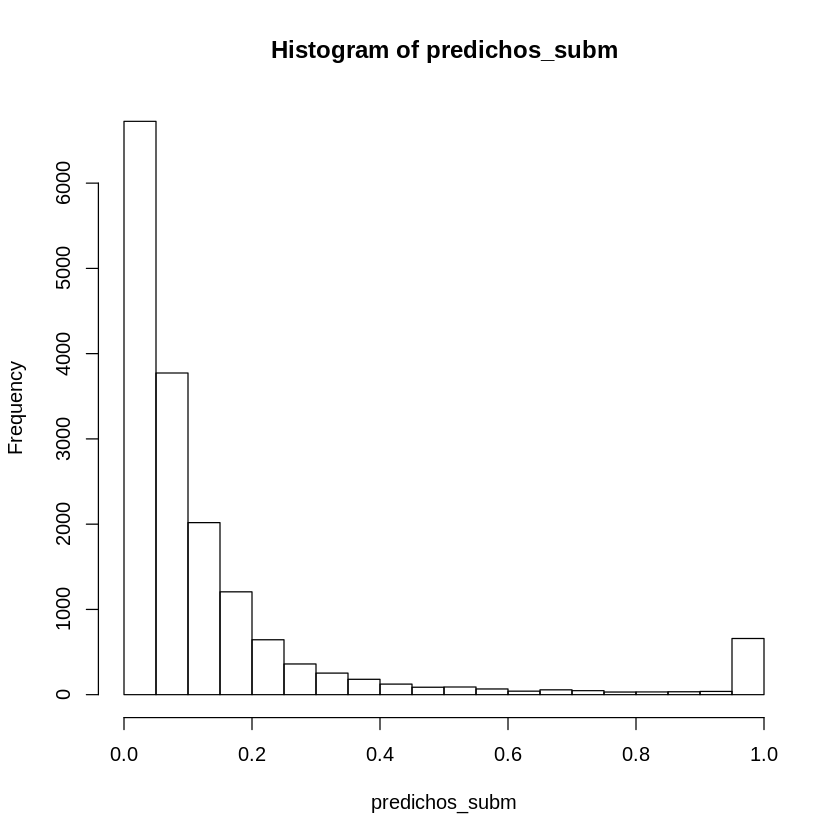

In [25]:
hist(predichos_subm)

# Agradecimientos



- El código para optimización bayesiana fue adaptado de [Joaquin Amat Rodrigruez](https://joaquinamatrodrigo.github.io/), con su tutorial [Optimización bayesiana de hiperparámetros](https://joaquinamatrodrigo.github.io/documentos/62_optimizacion_bayesiana_hiperparametros.html#h2o_y_rbayesianoptimization). Agradecido por sus grandiosos tutoriales.